# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$.
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки.
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вкршину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии.

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random
from pprint import pprint

Код для расчёта энтропии:

In [ ]:
def entropy(y):

    _, counts = np.unique(y, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер.

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения дерева (используйте `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признакоd и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три из разными критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [ ]:
class Node:
  def __init__(self, left, right, feature, t, is_leaf, depth, data):
    self.left = left
    self.right = right
    self.t = t
    self.is_leaf = is_leaf
    self.depth = depth
    self.data = data

class Tree:
  def __init__(self, max_depth = np.inf, purity = 0, min_leafs = 0, max_leafs = np.inf, max_features = None):
    self.max_depth = max_depth
    self.purity = purity
    self.min_leafs = min_leafs
    self.max_leafs = max_leafs
    self.max_features = max_features
    self.nodes = []
    self.depth = 0
    self.leaf_n = 0

  def IG(self, R_v, R_left, R_right):
    mode_Rlv = R_left.shape[0] / R_v.shape[0]
    mode_Rrv = R_right.shape[0] / R_v.shape[0]
    return entropy(R_v) - (mode_Rlv * entropy(R_left) + mode_Rrv * entropy(R_right))

  def best_t(self, X, y, features):
    best_feature = features[0]
    grid = np.linspace(X[best_feature].min(), X[best_feature].max(), 10)
    best_t = grid[0]
    best_IG = -1
    IG = -1
    feat = features
    if not (self.max_features is None):
      k = len(features)
      if (self.max_features == 'sqrt'):
        k  = int(np.sqrt(len(features)) // 1)
      feat = random.sample(features, k)
    for i in range(len(feat)):
      grid = np.linspace(X[feat[i]].min(), X[feat[i]].max(), 30)
      for t in grid:
        sample1 = y[X[feat[i]] < t]
        sample2 = y[X[feat[i]] >= t]
        ig = self.IG(y, sample1, sample2)
        if ig > best_IG:
          best_t, best_IG, best_feature  = t, ig, feat[i]
    return best_t, best_feature

  def SplitNode(self, X, y, features):
    best_t, best_feat = self.best_t(X, y, features)
    self.nodes[-1].feature = best_feat
    self.nodes[-1].t = best_t

    cur_node = len(self.nodes) - 1
    # 1) tree depth = 5
    # 2) purity - each element is from one class
    # 3) min odj in leaves = 5
    if ((self.nodes[-1].depth == self.max_depth) or
        (len(np.unique(y)) == self.purity) or
        (len(y[X[best_feat] < best_t]) < self.min_leafs and len(y[X[best_feat] >= best_t]) < self.min_leafs) or
        (len(y[X[best_feat] < best_t]) == 0 or len(y[X[best_feat] >= best_t]) == 0)):
      self.nodes[-1].is_leaf = True
      self.leaf_n += 1
      return
    else:
      if (len(y[X[best_feat] < best_t]) >= self.min_leafs):
        self.nodes[cur_node].left = len(self.nodes)
        self.nodes.append(Node(None, None, None, None, False, self.nodes[cur_node].depth + 1, y[X[best_feat] < best_t]))
        self.SplitNode(X[X[best_feat] < best_t], y[X[best_feat] < best_t], features)
      # 4) max leafs = 5
      if self.leaf_n == self.max_leafs:
        self.depth = max(self.nodes[cur_node].depth, self.depth)
        return
      if (len(y[X[best_feat] >= best_t]) >= self.min_leafs):
        self.nodes[cur_node].right = len(self.nodes)
        self.nodes.append(Node(None, None, None, None, False, self.nodes[cur_node].depth + 1, y[X[best_feat] >= best_t]))
        self.SplitNode(X[X[best_feat] >= best_t], y[X[best_feat] >= best_t], features)
      self.depth = max(self.nodes[cur_node].depth, self.depth)

  # fit
  def fit(self, X, y, features):
    self.depth = 1
    # no 1) none left, 2) none right, 3) none feature 4) none t, 5) isn't leaf, 6) Y is data
    self.nodes.append(Node(None, None, None, None, False, 1, y))
    self.SplitNode(X, y, features)

  def predict(self, X):
    y_predict = []
    for i in X.index:
      node = self.nodes[0]
      while True:
        if (node.is_leaf):
          break
        if (X[node.feature][i] < node.t):
          if (node.left is None):
            break
          node = self.nodes[node.left]
        else:
          if (node.right is None):
            break
          node = self.nodes[node.right]
      y_predict.append(pd.DataFrame(node.data).value_counts().idxmax()[0])
    return y_predict

  def scores(self, X):
    y_score = []
    for i in X.index:
      node = self.nodes[0]
      while True:
        if (node.is_leaf):
          break
        if (X[node.feature][i] < node.t):
          if (node.left is None):
            break
          node = self.nodes[node.left]
        else:
          if (node.right is None):
            break
          node = self.nodes[node.right]
      y_score.append((pd.DataFrame(node.data).value_counts().max() / len(node.data)))
    return y_score


In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)
X_train = pd.DataFrame(data=X_train, columns=iris['feature_names'])
X_test = pd.DataFrame(data=X_test, columns=iris['feature_names'])

In [ ]:
tree1 = Tree(max_depth=5, max_leafs=5, min_leafs=5, purity=1)
tree1.fit(X=X_train, y=y_train, features=iris['feature_names'])

tree2 = Tree(max_depth=5)
tree2.fit(X=X_train, y=y_train, features=iris['feature_names'])

tree3 = Tree(max_leafs=5)
tree3.fit(X=X_train, y=y_train, features=iris['feature_names'])

tree4 = Tree(min_leafs=5)
tree4.fit(X=X_train, y=y_train, features=iris['feature_names'])

tree5 = Tree(min_leafs=5)
tree5.fit(X=X_train, y=y_train, features=iris['feature_names'])

In [ ]:
y_predicted1 = tree1.predict(X_test)
y_predicted2 = tree2.predict(X_test)
y_predicted3 = tree3.predict(X_test)
y_predicted4 = tree4.predict(X_test)
y_predicted5 = tree5.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

scope1 = accuracy_score(y_test, y_predicted1)
scope2 = accuracy_score(y_test, y_predicted2)
scope3 = accuracy_score(y_test, y_predicted3)
scope4 = accuracy_score(y_test, y_predicted4)
scope5 = accuracy_score(y_test, y_predicted5)
print("Scope, when uses all parameters: ", scope1)
print("Scope, when max_depth=5: ", scope2)
print("Scope, when max_leafs=5: ", scope3)
print("Scope, when min_leafs=5: ", scope4)
print("Scope, when purity=1: ", scope5)

Scope, when uses all parameters:  0.98
Scope, when max_depth=5:  0.98
Scope, when max_leafs=5:  0.68
Scope, when min_leafs=5:  0.98
Scope, when purity=1:  0.98


##  Случайный лес

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес".

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [ ]:
class RandForest:
  def __init__(self, n = 5, max_depth = np.inf, min_leafs = 0):
    self.n = n
    self.trees = []
    for i in range(n):
      self.trees.append(Tree(max_depth=max_depth, min_leafs=min_leafs, max_features='sqrt'))


  def rand_samples(self, X, y):
    indexes = np.random.permutation(len(X))
    return X.iloc[indexes], y.iloc[indexes]

  def fit(self, X, y, features):
    for i in range(self.n):
      X_rand, y_rand = self.rand_samples(X, y)
      self.trees[i].fit(X_rand, np.array(y_rand), features)

  def predict(self, X):
    y_predicted = []
    for i in range(self.n):
      y_predicted.append(self.trees[i].predict(X))
    votes = pd.DataFrame(y_predicted).value_counts().idxmax()
    return votes

  def scores(self, X):
    y_predicted = []
    scores = []
    for i in range(self.n):
      y_predicted.append(self.trees[i].predict(X))
    for i in range(len(y_predicted[0])):
      count = pd.DataFrame(y_predicted)[i].value_counts()
      max_val = count.max()
      idmax = count.idxmax()
      if idmax == 0:
        scope = 1.0 - max_val / self.n
      else:
        scope = max_val / self.n
      scores.append(scope)
    return scores


In [ ]:
%%capture
!wget https://www.dropbox.com/s/qtwjydw8ntvwteg/churn.csv

churn = pd.read_csv("churn.csv")

In [ ]:
churn

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [ ]:
churn.info() # no empty

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Столбцы **CustomerId, RowNumber** не нужны, так как они уникальны

In [ ]:
# check
print(len(churn['CustomerId'].unique()))
print(len(churn['RowNumber'].unique()))
print(len(churn['Surname'].unique())) # but id is different

10000
10000
2932


In [ ]:
churn = churn.drop('CustomerId', axis=1)
churn = churn.drop('RowNumber', axis=1)
churn = churn.drop('Surname', axis=1)

In [ ]:
country = pd.DataFrame(churn['Geography'].unique(), columns=['Geography'])
print(country.Geography[0])
print(country)
for i in range(len(country)):
  churn.loc[(churn.Geography == country.Geography[i]), 'Geography'] = country.index[i]
print(churn)

gender = pd.DataFrame(churn['Gender'].unique(), columns=['Gender'])
print(gender.Gender[0])
print(gender)
for i in range(len(gender)):
  churn.loc[(churn.Gender == gender.Gender[i]), 'Gender'] = gender.index[i]
print(churn)

France
  Geography
0    France
1     Spain
2   Germany
      CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0             619         0  Female   42       2       0.00              1   
1             608         1  Female   41       1   83807.86              1   
2             502         0  Female   42       8  159660.80              3   
3             699         0  Female   39       1       0.00              2   
4             850         1  Female   43       2  125510.82              1   
...           ...       ...     ...  ...     ...        ...            ...   
9995          771         0    Male   39       5       0.00              2   
9996          516         0    Male   35      10   57369.61              1   
9997          709         0  Female   36       7       0.00              1   
9998          772         2    Male   42       3   75075.31              2   
9999          792         0  Female   28       4  130142.79              1   

      Ha

In [ ]:
data_points = churn.drop('Exited', axis=1)
data_values = churn['Exited']

X_train1, X_test1, y_train1, y_test1 = train_test_split(data_points, data_values, test_size=0.33, random_state=42)
features = list(pd.DataFrame(X_train1).columns)
#y_test1 = np.array(y_test1)
#y_train1 = np.array(y_train1)
print(features)

['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [ ]:
forest = RandForest(n = 5)
forest.fit(X_train1, y_train1, features)
#y_predicted = forest.predict(X_test)

In [ ]:
y_predicted = forest.predict(X_test1)
print(accuracy_score(y_test1, y_predicted))

0.7936363636363636


In [ ]:
# use different parameters
tree_n = np.arange(50, 80, 10)
max_depth = np.arange(10, 20, 5)
min_samples_leafs = np.arange(5, 7)

best_n, best_max_depth, best_min_leafs, best_scope = 50, 1, 1, -1.0

for n in tree_n:
  for depth in max_depth:
    for leafs in min_samples_leafs:
      forest = RandForest(n=n, max_depth=depth,min_leafs=leafs)
      forest.fit(X_train1, y_train1, features)
      y_predicted = forest.predict(X_test1)
      scope = accuracy_score(y_test1, y_predicted)
      print(scope)
      if scope > best_scope:
        best_n, best_max_depth, best_min_leafs, best_scope = n, depth, leafs, best_scope

print("Best accuracy scope: ", best_scope)
print("Best tree n: ", best_n)
print("Best max depth: ", best_max_depth)
print("Best min sample leafs: ", best_min_leafs)

0.8433333333333334
0.8472727272727273
0.8375757575757575
0.8281818181818181
0.8478787878787879
0.8412121212121212


KeyboardInterrupt: ignored

In [ ]:
tree_n = np.arange(35, 50, 5)

best_n, best_max_depth, best_min_leafs, best_scope = 50, 1, 1, -1.0

for n in tree_n:
  forest = RandForest(n=n, max_depth=10,min_leafs=6)
  forest.fit(X_train1, y_train1, features)
  y_predicted = forest.predict(X_test1)
  scope = accuracy_score(y_test1, y_predicted)
  print(scope, n, 10)
  if scope > best_scope:
    best_n, best_max_depth, best_min_leafs, best_scope = n, 10, 6, scope

print("Best accuracy scope: ", best_scope)
print("Best tree n: ", best_n)
print("Best max depth: ", best_max_depth)
print("Best min sample leafs: ", best_min_leafs)

0.8372727272727273 35 10
0.8412121212121212 40 10
0.843030303030303 45 10
Best accuracy scope:  0.843030303030303
Best tree n:  45
Best max depth:  10
Best min sample leafs:  6


Наилучшие гиперпараметры для реализации получились:
6 - максимальная глубина;
10 - минимальное количество листьев;
кол-во деревьев для алгоритма, дающее науличшие результаты примерно от 35 до 45.

In [ ]:
forest2 = RandForest(n=40, max_depth=10,min_leafs=6)
forest2.fit(X_train1, y_train1, features)
y_predicted2 = forest2.predict(X_test1)
print(accuracy_score(y_test1, y_predicted2))

0.8521212121212122


In [ ]:
# важность признаков:
tmp = []
for tree in forest2.trees:
  for node in tree.nodes:
    tmp.append(node.feature)
feat_imp_t = pd.DataFrame(tmp, columns=['feat'])
feat_imp_t.groupby('feat').size().sort_values(ascending=False) / len(feat_imp_t)

feat
Age                0.156813
EstimatedSalary    0.152430
Balance            0.147729
CreditScore        0.145817
Tenure             0.109721
NumOfProducts      0.079681
Geography          0.060797
Gender             0.050199
HasCrCard          0.049562
IsActiveMember     0.047251
dtype: float64

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
forest2 = RandForest(n=40, max_depth=10, min_leafs=6)
forest2.fit(X_train1, y_train1, features)

y_score1 = forest.scores(X_test1)
y_score2 = forest2.scores(X_test1)

print("ROC-AUC before finding parameters: ", roc_auc_score(y_test1, y_score1))
print("ROC-AUC before finding parameters: ", roc_auc_score(y_test1, y_score2))

NameError: ignored

In [ ]:
from sklearn.metrics import roc_auc_score
print("ROC-AUC before finding parameters: ", roc_auc_score(y_test1, y_score1))
print("ROC-AUC before finding parameters: ", roc_auc_score(y_test1, y_score2))

ROC-AUC before finding parameters:  0.8000756240594551
ROC-AUC before finding parameters:  0.8294583807203133


Чем ближе значение параметра к единице, тем лучше

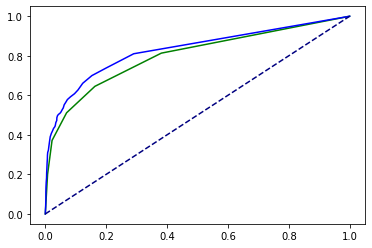

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr1, tpr1, treshold1 = roc_curve(y_test1, y_score1)
fpr2, tpr2, treshold2 = roc_curve(y_test1, y_score2)
roc_auc = auc(fpr1, tpr1)
roc_auc = auc(fpr2, tpr2)

plt.plot(fpr1, tpr1, color='green')
plt.plot(fpr2, tpr2, color='blue')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()